In [1]:
import bz2
import os
import datetime
import urllib.request
import pyproj

import numpy as np
import pandas as pd
import xarray as xr
import scipy.spatial as ss

import wradlib as wrl
from pysteps import motion, nowcasts
from pysteps.utils import transformation

os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras.models import load_model
from efficientnet.tfkeras import EfficientNetB4
import segmentation_models as sm

import matplotlib.pyplot as plt
%matplotlib inline

Pysteps configuration file found at: /home/georgy/miniforge3/envs/innomaus_nowcasting/lib/python3.9/site-packages/pysteps/pystepsrc



2024-07-02 14:28:52.450696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [2]:
# we need to find something with rain at the moment
# https://kachelmannwetter.com/de/regenradar/deutschland

# Stuttgart
#city_lon = 9.168629653588768
#city_lat = 48.797727681701346

# Berlin
#city_lon = 13.404954
#city_lat = 52.520008

# Wiesbaden
city_lon = 8.237355726644166
city_lat = 50.06178786326219

In [3]:
# the set of function for radar data processing
def ll2xy(longitude, latitute):

    # define a radolan projection via PROJ.4 definition
    dwd_string = ('+proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 '
                  '+x_0=0 +y_0=0 +a=6370040 +b=6370040 +to_meter=1000 +no_defs')

    # initialize source and target projections
    proj_wgs = pyproj.CRS('EPSG:4326')
    proj_dwd = pyproj.CRS.from_proj4(dwd_string)

    # Create a PyProj transformer for the conversion
    transformer = pyproj.Transformer.from_crs(proj_wgs, proj_dwd, always_xy=True)
    
    # Perform the transformation
    _x, _y = transformer.transform(longitude, latitute)

    # konvert km to m
    _x *= 1000
    _y *= 1000

    return _x, _y

def download_and_read_RY(RY_timestamp):
    
    # RY_timestamp is in the form of "%y%m%d%H%M" i.e. 2310271030, (20)23 10 27 10:30
    
    url = f"https://opendata.dwd.de/weather/radar/radolan/ry/raa01-ry_10000-{RY_timestamp}-dwd---bin.bz2"
    data_compressed = urllib.request.urlopen(url).read()
    data_decompressed = bz2.decompress(data_compressed)
    
    data_xr = wrl.io.radolan.open_radolan_dataset(data_decompressed)
    
    return data_xr.load()


def download_data():
    
    # downloads latest available input data
    
    latest_scan = download_and_read_RY("latest")
    
    latest_datetime = pd.to_datetime(latest_scan.time.values[0])
    
    list_for_downloading = [ts.strftime("%y%m%d%H%M") for ts in 
    [latest_datetime - datetime.timedelta(minutes=t) for t in [15, 10, 5]]]
    
    previous_scans = [download_and_read_RY(ts) for ts in list_for_downloading]
    
    previous_scans.append(latest_scan)
    
    data = xr.concat(previous_scans, dim="time").load()
    
    return data


def clip_data(data_instance, point_longitude, point_latitute, size=256):

    # transform coordinates
    point_x, point_y = ll2xy(point_longitude, point_latitute)

    # get a half-size in meters
    half_size = int(size/2) * 1000

    # clip respective region
    di_clip = data_instance.sel(x=slice(point_x - half_size, point_x + half_size), 
                                y=slice(point_y - half_size, point_y + half_size)).copy()

    return di_clip

In [5]:
data_latest = download_data()
data_clipped = clip_data(data_latest, city_lon, city_lat)
print(data_clipped)

CRS
CRS
CRS
CRS
<xarray.Dataset> Size: 1MB
Dimensions:  (time: 4, y: 256, x: 256)
Coordinates:
  * time     (time) datetime64[ns] 32B 2024-07-02T12:10:00 ... 2024-07-02T12:...
  * y        (y) float64 2kB -4.444e+06 -4.443e+06 ... -4.19e+06 -4.189e+06
  * x        (x) float64 2kB -2.6e+05 -2.59e+05 ... -5.962e+03 -4.962e+03
Data variables:
    RY       (time, y, x) float32 1MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.29.1
    radarlocations:  ['asb', 'boo', 'ros', 'hnr', 'umd', 'pro', 'ess', 'fld',...


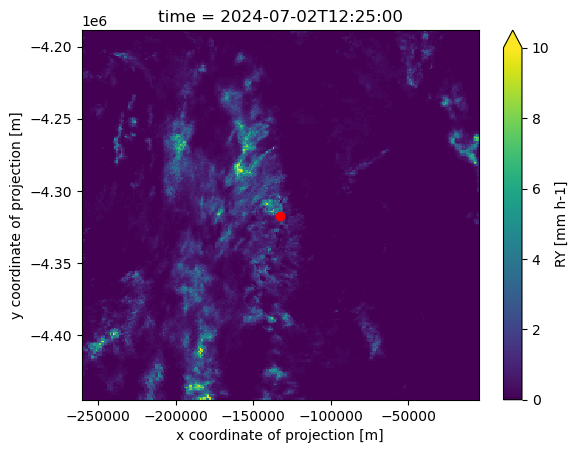

In [6]:
# visualize what has been clipped
data_clipped["RY"].isel(time=3).plot(vmax=10)
city_x, city_y = ll2xy(city_lon, city_lat)
plt.scatter(city_x, city_y, color='red', label='Point')

In [7]:
# get simple numpy arrays as input
data_input = data_clipped["RY"].to_numpy()
data_input = np.nan_to_num(data_input)

In [8]:
def pysteps_nowcast(data_instance, lookback=2, pred_ts=12):
    """
        
    """    
    # input data
    # two last scans
    inputs_mmh = data_instance[ -lookback: , ::, ::]

    ### nowcasting steps
    # data transformation mm/h --> dB (reflectivity)
    inputs_dbr = transformation.dB_transform(inputs_mmh, threshold=0.1, zerovalue=-15.0)[0]
    
    # calculate optical flow with the Lukas-Kanade method
    V = motion.get_method("LK")(inputs_dbr)

    # run the model
    nowcast_dbr = nowcasts.get_method("extrapolation")(inputs_dbr[-1, :, :], V, pred_ts)

    # convert back to mm/h
    nowcast_mmh = transformation.dB_transform(nowcast_dbr, threshold=-10.0, inverse=True)[0]

    # sanity check for NaNs (filling with zeros)
    nowcast_mmh[np.isnan(nowcast_mmh)] = 0
    
    return nowcast_mmh

In [9]:
# pysteps nowcast with 5-min lead time for the next 12 timesteps (i.e. 1 hour)
pysteps_predictions = pysteps_nowcast(data_input)

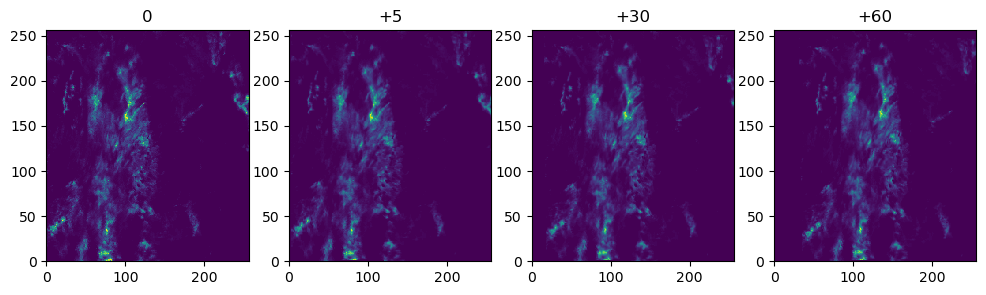

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))

axes[0].pcolormesh(data_input[-1], vmax=10)
axes[1].pcolormesh(pysteps_predictions[0], vmax=10)
axes[2].pcolormesh(pysteps_predictions[5], vmax=10)
axes[3].pcolormesh(pysteps_predictions[11], vmax=10)

for i, t in enumerate(["0", "+5", "+30", "+60"]):
    axes[i].set_title(t)

In [11]:
# path to DL models
path_dl_models = "models/"
rainnet2024 = load_model(os.path.join(path_dl_models, "rainnet2024.keras"))

In [12]:
def rainnet2024_nowcast(data_instance, model_instance=rainnet2024, pred_ts=12):

    # preprocessing
    data_instance = data_instance.astype(np.float32)
    
    # rainnet2024 takes mm/h divided by 400
    data_instance = data_instance / 400.0

    # move scans dimension to the last position
    data_instance = np.moveaxis(data_instance, 0, -1)

    # create a virtual "batch=1" dimension
    data_instance = data_instance[np.newaxis, ...]

    nowcast = []

    for j in range(pred_ts):
        # make prediction
        pred = model_instance.predict(data_instance, verbose=0)
        # append prediction to holder
        nowcast.append(pred)
        # append prediction to the input shifted on one step ahead
        data_instance = np.concatenate([data_instance[::, ::, ::, 1:], pred], axis=-1)

    # postprocessing
    # the shape of nowcast is predts, batch=1, w, h, 1
    # --> predts, w, h
    nowcast = np.squeeze(nowcast)
    # convert from div400 to mm/h
    nowcast = nowcast * 400.0
    # Get rid of infs and Nans
    nowcast[~np.isfinite(nowcast)] = 0
    # Get rid of negative values
    nowcast = np.where(nowcast<0, 0, nowcast)

    return nowcast

In [13]:
rainnet_predictions = rainnet2024_nowcast(data_input)

Text(0, 0.5, 'rainnet2024')

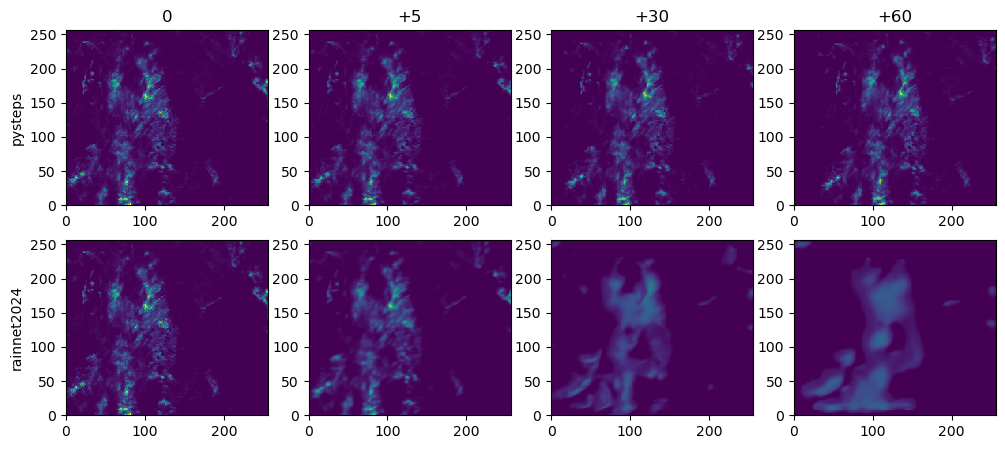

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,5))

axes[0,0].pcolormesh(data_input[-1], vmax=10)
axes[1,0].pcolormesh(data_input[-1], vmax=10)

axes[0,1].pcolormesh(pysteps_predictions[0], vmax=10)
axes[0,2].pcolormesh(pysteps_predictions[5], vmax=10)
axes[0,3].pcolormesh(pysteps_predictions[11], vmax=10)

axes[1,1].pcolormesh(rainnet_predictions[0], vmax=10)
axes[1,2].pcolormesh(rainnet_predictions[5], vmax=10)
axes[1,3].pcolormesh(rainnet_predictions[11], vmax=10)

for i, t in enumerate(["0", "+5", "+30", "+60"]):
    axes[0,i].set_title(t)

axes[0,0].set_ylabel("pysteps")
axes[1,0].set_ylabel("rainnet2024")

In [15]:
# now we are going to prediction of threshold exceedances

In [16]:
def predict_mask(data_instance, model_instance):
        
    # preprocessing
    data_instance = data_instance.astype(np.float32)
    
    # each model takes mm/h divided by 400
    data_instance = data_instance / 400.0
    
    # move scans dimension to the last position
    data_instance = np.moveaxis(data_instance, 0, -1)

    # create a virtual "batch=1" dimension
    data_instance = data_instance[np.newaxis, ...]
    
    # run the model
    nowcast = model_instance.predict(data_instance, verbose=0)

    # postprocessing
    nowcast = np.squeeze(nowcast)
    
    return nowcast

In [17]:
thresholds = [5, 10, 15, 20, 25, 30, 40]
custom_objects={'jaccard_loss': sm.losses.JaccardLoss(),
                'iou_score': sm.metrics.IOUScore(),
                'bce_loss': sm.losses.BinaryCELoss()}

In [18]:
unet_predictions = []

for threshold in thresholds:

    model = load_model(os.path.join(path_dl_models, f"rainnet2024s_{threshold}.keras"),
                       custom_objects=custom_objects)
    
    mask = predict_mask(data_input, model)

    unet_predictions.append(mask)

unet_predictions = np.array(unet_predictions)

In [19]:
# calculate accumulations for other models
pysteps_accum = pysteps_predictions.sum(axis=0)/12
rainnet2024_accum = rainnet_predictions.sum(axis=0)/12

In [20]:
# define threshold to check
THR = 5

# check whether there is an exceedance of defined threshold (THR)
pysteps_accum.max()>=THR, rainnet2024_accum.max()>=THR, unet_predictions[thresholds.index(THR)].max()>=0.5

(False, False, True)

Text(0, 0.5, 'unet')

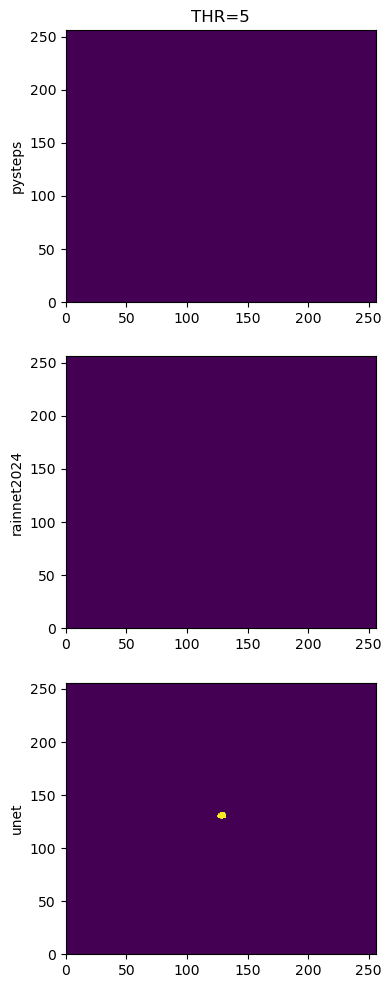

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4,12))

axes[0].pcolormesh(pysteps_accum >= THR)
axes[1].pcolormesh(rainnet2024_accum >= THR)
axes[2].pcolormesh(unet_predictions[thresholds.index(THR)])

axes[0].set_title(f"THR={THR}")

axes[0].set_ylabel("pysteps")
axes[1].set_ylabel("rainnet2024")
axes[2].set_ylabel("unet")